In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
class Layer:
    """define a layer object"""
    
    def __init__(self, n_input, n_output=None, random_seed=42):
        """Constructer of a layer object"""
        
        self.n_input = n_input
        self.n_output = n_output
        
        bound = np.sqrt(1. / self.n_input)
        np.random.seed(random_seed)
        self.weights = np.random.uniform(-bound, bound, size=(self.n_input, self.n_output))

    def _sigmoid_forward(self, x):
        """Apply sigmoid function"""
        
        return 1 / (1 + np.exp(-x))
    
    def _tanh_forward(self, x):
        """Apply tanh function""" 
        return (np.exp(2*x) - 1) / (np.exp(2*x) + 1)
    
    def forward_prop(self, input_x, activation_func='sigmoid', add_noise=False):
        """Implement forward propagation"""
        # add gaussian noises to input
        if add_noise:
            input_x += np.random.normal(0, 0.05, size=input_x.shape)
        
        if activation_func == 'sigmoid':
            self.out_x = self._sigmoid_forward(np.dot(input_x, self.weights))
        elif activation_func == 'tanh':
            self.out_x = self._tanh_forward(input_x.dot(self.weights))

    def backward_prop(self, x_pre, delta_next, weights_next, eta, activation_func='sigmoid'):
        """Implement backward propagation"""
        
        if activation_func == 'sigmoid':
            self.delta = self.out_x * (1-self.out_x) * np.dot(delta_next, weights_next.T)
        elif activation_func == 'tanh':
            self.delta = (1 - np.square(self._tanh_forward(self.out_x))) * np.dot(delta_next, weights_next.T)
       
        self.weights -= eta * x_pre.T.dot(self.delta) / x_pre.shape[0]
    
class Softmax_Layer(Layer):
    """define a output layer object"""
    
    def __init__(self, n_input, n_output=None, random_seed=42):
        """Constructer of a output layer object"""
            
        Layer.__init__(self, n_input, n_output, random_seed)
    
    def _softmax(self, out_x):
        return np.exp(out_x) / np.sum(np.exp(out_x))
    
    def forward_prop(self, input_x):
        """Implement forward propagation"""
        
        self.out_x = np.dot(input_x, self.weights)
        
    def backward_prop(self, y_true, x_pre, eta):
        """Implement backward propagation (output layer)"""
        
        pred_proba = self.pred_proba()
        # derivative of cross entropy loss with softmax
        self.delta = pred_proba - y_true
        
        self.weights -= eta * np.dot(x_pre.T, self.delta) / x_pre.shape[0]
    
    def pred_proba(self):
        """produce hypothesis vector"""
        
        return np.apply_along_axis(self._softmax, 1, self.out_x)
    
    def predict(self):
        """Predict labels"""
        
        pred_proba = self.pred_proba()
        return (pred_proba == pred_proba.max(axis=1)[:, None]).astype(int)
    
    def compute_mse(self, y_true):
        """Compute mean square error"""
        
        pred_proba = self.pred_proba()
        return np.mean(np.square(pred_proba - y_true))
    
    def compute_miscla_rate(self, y_true):
        """Compute misclassification rate"""
        
        return 1 - np.sum(np.all(output_layer.predict() == y_true, axis=1)) / y_true.shape[0]

### XOR Problem

In [3]:
X = np.array([[1, 0, 0], [1, 1, 0], [1, 0, 1], [1, 1, 1]])
y = np.array([[0, 1], [1, 0], [1, 0], [0, 1]])

In [4]:
epochs = 55000
end_epoch = epochs # equal to epochs or the epoch at which point the miscla. rate is 0

n_neurons = 2
fc_layer = Layer(X.shape[1], n_neurons)
output_layer = Softmax_Layer(n_neurons, 2)

errors = np.zeros(epochs)

In [5]:
for epoch in range(epochs):
    fc_layer.forward_prop(X)
    output_layer.forward_prop(fc_layer.out_x)
    
    output_layer.backward_prop(y, x_pre=fc_layer.out_x, eta=0.4)
    fc_layer.backward_prop(x_pre=X, delta_next=output_layer.delta, weights_next=output_layer.weights, eta=0.4)
    
    errors[epoch] = output_layer.compute_mse(y)
    
    if output_layer.compute_miscla_rate(y) == 0:
        end_epoch = epoch
        break

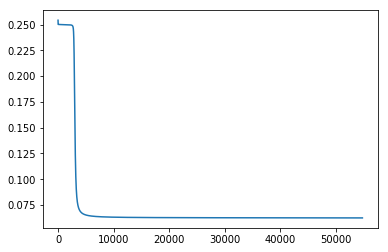

In [6]:
# predictions were all correct after 54844th epoch
plt.plot(errors[:end_epoch])

### Digit Classification

In [7]:
# load data
X = np.loadtxt('input/mfeat-pix.txt')

# normalize data
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

# add bias term
X = np.column_stack([np.ones(X.shape[0]), X])

In [8]:
# split the dataset into training data and test data
train_indices = [range(0 + 200*i, 50 + 200*i) for i in range(10)]
cv_indices = [range(50 + 200*i, 100 + 200*i) for i in range(10)]
test_indices = [range(100 + 200*i, 200 + 200*i) for i in range(10)]

X_train = X[train_indices, ].reshape(500, 241)
X_cv = X[cv_indices, ].reshape(500, 241)
X_test = X[test_indices, ].reshape(1000, 241)

In [9]:
# create class labels for cross-validation
nb_classes = 10
y_vector = np.array([i for i in range(10) for j in range(50)])
y_matrix = np.eye(nb_classes)[y_vector]

In [11]:
for epoch in range(epochs):
    
    fc_layer1.forward_prop(X_train, activation_func='tanh', add_noise=True)
    fc_layer2.forward_prop(fc_layer1.out_x, activation_func='tanh', add_noise=True)
    fc_layer3.forward_prop(fc_layer2.out_x, activation_func='tanh', add_noise=True)
    output_layer.forward_prop(fc_layer3.out_x)
    
    train_mis[epoch] = output_layer.compute_miscla_rate(y_matrix)
    
    output_layer.backward_prop(y_matrix, x_pre=fc_layer3.out_x, eta=0.01)
    fc_layer3.backward_prop(x_pre=fc_layer2.out_x, activation_func='tanh', delta_next=output_layer.delta, weights_next=output_layer.weights, eta=0.01)
    fc_layer2.backward_prop(x_pre=fc_layer1.out_x, activation_func='tanh', delta_next=fc_layer3.delta, weights_next=fc_layer3.weights, eta=0.01)
    fc_layer1.backward_prop(x_pre=X_train, activation_func='tanh', delta_next=fc_layer2.delta, weights_next=fc_layer2.weights, eta=0.01)
    
    fc_layer1.forward_prop(X_cv, activation_func='tanh')
    fc_layer2.forward_prop(fc_layer1.out_x, activation_func='tanh')
    fc_layer3.forward_prop(fc_layer2.out_x, activation_func='tanh')
    output_layer.forward_prop(fc_layer3.out_x)
    
    cv_mis[epoch] = output_layer.compute_miscla_rate(y_matrix)

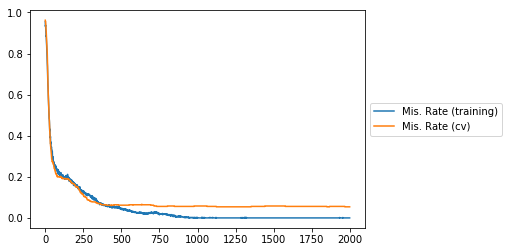

In [12]:
# plot 
plt.plot(train_mis) 
plt.plot(cv_mis)

# training error reached 0 at 941st epoch
plt.legend(['Mis. Rate (training)', 'Mis. Rate (cv)'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [13]:
# merge training and cv dataset
train_indices = [range(0 + 200*i, 100 + 200*i) for i in range(10)]
X_train = X[train_indices, ].reshape(1000, 241)

In [14]:
# create class labels for prediction
y_vector = np.array([i for i in range(10) for j in range(100)])
y_matrix = np.eye(nb_classes)[y_vector]

In [15]:
# reinitialize parameters
epochs = 850
neurons_1 = 256
neurons_2 = 128
neurons_3 = 128
fc_layer1 = Layer(X.shape[1], neurons_1)
fc_layer2 = Layer(neurons_1, neurons_2)
fc_layer3 = Layer(neurons_2, neurons_3)
output_layer = Softmax_Layer(neurons_3, 10)

train_mis = np.zeros(epochs)
test_mis = np.zeros(epochs)

In [16]:
for epoch in range(epochs):
    
    fc_layer1.forward_prop(X_train, activation_func='tanh', add_noise=True)
    fc_layer2.forward_prop(fc_layer1.out_x, activation_func='tanh', add_noise=True)
    fc_layer3.forward_prop(fc_layer2.out_x, activation_func='tanh', add_noise=True)
    output_layer.forward_prop(fc_layer3.out_x)
    
    train_mis[epoch] = output_layer.compute_miscla_rate(y_matrix)
    
    output_layer.backward_prop(y_matrix, x_pre=fc_layer3.out_x, eta=0.01)
    fc_layer3.backward_prop(x_pre=fc_layer2.out_x, activation_func='tanh', delta_next=output_layer.delta, weights_next=output_layer.weights, eta=0.01)
    fc_layer2.backward_prop(x_pre=fc_layer1.out_x, activation_func='tanh', delta_next=fc_layer3.delta, weights_next=fc_layer3.weights, eta=0.01)
    fc_layer1.backward_prop(x_pre=X_train, activation_func='tanh', delta_next=fc_layer2.delta, weights_next=fc_layer2.weights, eta=0.01)

In [17]:
fc_layer1.forward_prop(X_test, activation_func='tanh')
fc_layer2.forward_prop(fc_layer1.out_x, activation_func='tanh')
fc_layer3.forward_prop(fc_layer2.out_x, activation_func='tanh')
output_layer.forward_prop(fc_layer3.out_x)
    
test_mis = output_layer.compute_miscla_rate(y_matrix)
print("The misclassification rate on the test dataset is: {0}".format(test_mis))

The misclassification rate on the test dataset is: 0.05500000000000005
